# Quantile Regression Toy Models

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
dir_datasets = Path('../../soil/datasets/')
pth_wise3_data = dir_datasets/'ISRIC_WISE/orgc_stock_ISRIC_WISE_clip.csv'

In [ ]:
wise3 = pd.read_csv(pth_wise3_data)
wise3.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
wise3.head()

,profile_id,orgc_stock_mineral,orgc_stock_organic,top_cm,bot_cm,mineral_fraction,organic_fraction,DATEYR,LATDD,LONDD
0,AL0007,12.11205,0.0,0,100,1.0,0.0,1994.0,41.06944,19.99556
1,AL0008,6.79968,0.0,0,100,1.0,0.0,1994.0,40.21500,20.64722
2,AL0010,15.78198,0.0,0,100,1.0,0.0,1994.0,40.34528,19.48361
3,AL0011,17.50674,0.0,0,100,1.0,0.0,1994.0,41.37778,19.77028
4,AL0012,7.55993,0.0,0,100,1.0,0.0,1994.0,40.65528,20.95889


In [ ]:
vars_X = ['LATDD', 'LONDD']
var_Y = 'orgc_stock_mineral'

In [ ]:
X = wise3[vars_X].values
Y = wise3[var_Y].values

In [ ]:
Y_scaled = preprocessing.scale(Y)
X_scaled = pd.DataFrame(preprocessing.scale(X), columns=vars_X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.2, random_state=5)

## Helpers

In [ ]:
def correctPcnt(df):
    correct = 0
    obs = df.shape[0]
    for i in range(obs):
        if df.loc[i,0.01] <= df.loc[i,'actual'] <= df.loc[i,0.99]:
            correct += 1
    print(correct/obs)
    
    

def showIntervals(ax, df):
    x = np.arange(len(df))
    y50 = df[0.5].values
    y95 = df[0.95].values
    y05 = df[0.05].values
    
    ax.scatter(x, y50, marker='.')
    ax.fill_between(x, y05, y95, color='red', alpha=0.1)
    return ax

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200, random_state=0, min_samples_split=20)

In [ ]:
%%time

rf.fit(X_train, Y_train)

CPU times: user 404 ms, sys: 10.3 ms, total: 414 ms
Wall time: 459 ms


RandomForestRegressor(min_samples_split=20, n_estimators=200, random_state=0)

In [ ]:
%%time 

# Get the predictions of all trees for all observations
# Each observation has N predictions from the N trees

pred_Q = pd.DataFrame()
for pred in rf.estimators_:
    temp = pd.Series(pred.predict(X_test).round(2))
    pred_Q = pd.concat([pred_Q,temp],axis=1)
pred_Q.head()

CPU times: user 491 ms, sys: 37.5 ms, total: 528 ms
Wall time: 571 ms


,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.16,0.61,0.05,0.58,0.22,0.03,0.10,0.13,0.50,0.14,...,0.24,0.12,0.36,0.12,0.18,0.02,0.90,0.07,0.09,-0.02
1,-0.04,0.18,-0.11,0.14,0.01,-0.11,-0.06,-0.07,0.29,0.02,...,0.25,-0.02,-0.08,-0.23,0.11,0.03,-0.10,-0.11,-0.02,-0.07
2,0.29,-0.21,-0.22,-0.09,0.13,-0.21,-0.28,-0.26,-0.27,-0.23,...,0.49,0.43,0.11,-0.26,-0.24,-0.21,-0.14,-0.20,-0.11,-0.01
3,-0.19,0.13,-0.14,-0.38,-0.15,-0.28,0.12,-0.19,0.05,0.33,...,-0.45,0.04,-0.20,0.13,-0.24,0.39,-0.14,0.29,-0.41,-0.16
4,-0.29,-0.28,-0.53,-0.45,-0.43,-0.38,-0.29,-0.24,-0.44,-0.44,...,-0.38,-0.47,-0.28,-0.39,-0.24,0.15,-0.45,-0.03,-0.39,-0.49


In [ ]:
quantiles = [0.01, 0.05, 0.50, 0.95 , 0.99]

R2 score is 0.15
0.7905405405405406


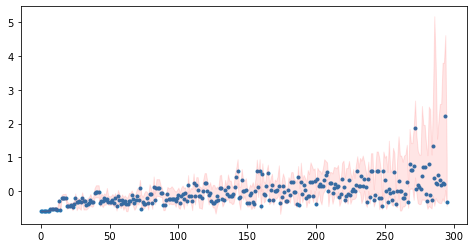

In [ ]:
RF_actual_pred = pd.DataFrame()

for q in quantiles:
    s = pred_Q.quantile(q=q, axis=1)
    RF_actual_pred = pd.concat([RF_actual_pred,s],axis=1,sort=False)

RF_actual_pred.columns = quantiles
RF_actual_pred['actual'] = Y_test
RF_actual_pred['interval'] = RF_actual_pred[np.max(quantiles)] - RF_actual_pred[np.min(quantiles)]
RF_actual_pred = RF_actual_pred.sort_values('interval')
RF_actual_pred = RF_actual_pred.round(2)
RF_actual_pred

# Get the R-squared
r2 = sklearn.metrics.r2_score(RF_actual_pred['actual'], RF_actual_pred[0.5]).round(2)
print('R2 score is {}'.format(r2) )  # 0.81

# Get the correct percentage
correctPcnt(RF_actual_pred) # 0.9509

# Show the intervals
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax = showIntervals(ax, RF_actual_pred) 

# References
- https://medium.com/dataman-in-ai/a-tutorial-on-quantile-regression-quantile-random-forests-and-quantile-gbm-d3c651af7516